Principal Components Analysis (PCA) and Principal Component Regression (PCR)
===

Author: Nathan A. Mahynski

Date: 2023/09/12

Description: Discussion and examples of [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and [PCR](https://en.wikipedia.org/wiki/Principal_component_regression).

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !pip install git+https://github.com/mahynski/pychemauth@main
    
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import utils

import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from pychemauth.preprocessing.scaling import CorrectedScaler

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-26-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

pychemauth: 0.0.0b3
numpy     : 1.24.3
json      : 2.0.9
watermark : 2.4.3
matplotlib: 3.7.2



<h3>Create some Data</h3>

For this notebook we will generate some synthetic data.  Here, we have a dataset with 2 features and a certain multivariate normal distribution.

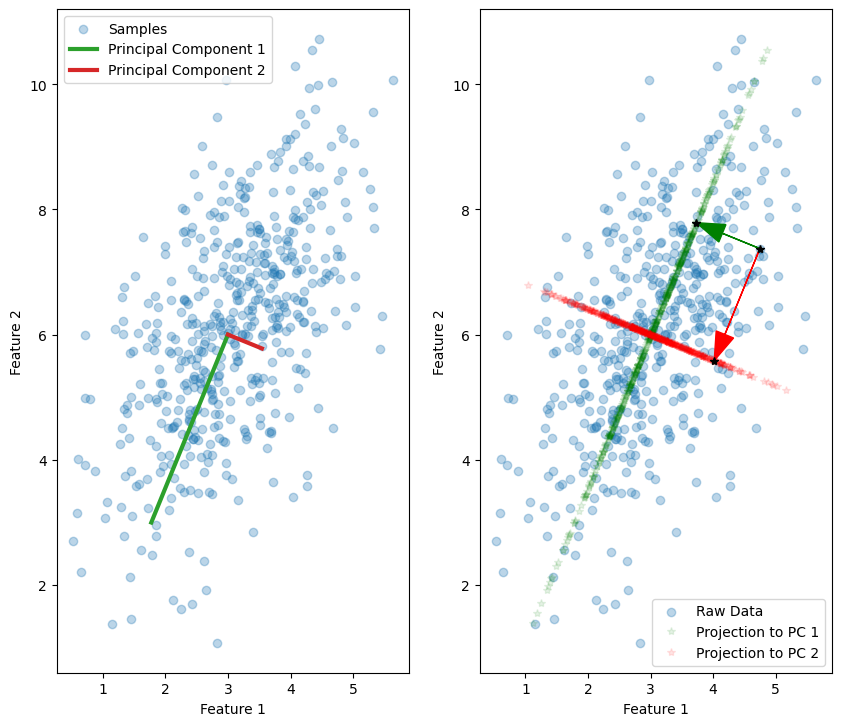

In [4]:
X = utils.generate_data(mean=[3,6], cov=[[1, 1], [1, 3]], n_samples=500)
utils.visualize_data(X, mean=[3,6])

In [242]:
# For this example, we will generate a response correlated with the first eigenvector (PC 1)
y, pca_gen = utils.generate_response(X, 0, mean=[3,6], seed=1, y_center=10, display=False) 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# As you can see the value of y is strongly correlated with PC1 and not at all with PC2.

Principal Components Analysis (PCA)
---

PCA stands for [principal components analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) This is often used as an unsupervised dimensionality reduction technique, and by itself does not provide a predictive model.  Regression or classification is often performed in the reduced space afterwards.  PCA is the first step in a number of authentication models like SIMCA.

PCA essentially finds the directions that maximize the covariance of mean-centered X ($\sim X^TX$ **up to a normalizing constant**), then projects the data into a lower dimension space made of the top eigenvectors.  The "top" eigenvectors are determined by the magnitude of the eigenvalue.  These represent the orthogonal directions in space that describe most of the data variation

Before performing PCA we (column-wise) center the data on the mean which is critical so that the eigenvectors "start" at the center of the data "cloud" and extend outward capturing how the data is distributed.  In fact, in sklearn's implementation of PCA the data is always internally centered in case the user forgot to do this! Data that is always centered will not be affected. Note that PCA is "unsupervised" which means we won't be using $Y$, and therefore we don't need to worry about those values. PCA is also **sensitive to data scaling**, so X must be standardized, or autoscaled, if features were measured on different scales (in different units) and we want to assign equal importance to all features. 

Basic steps:
1. Mean center $X$, where $X$ has shape $n \times p$. (optionally also scale the data)
2. Build covariance matrix, $cov(X^T) = X^TX / (n-1)$. Sometimes $n$ not $n-1$ is used.
3. Find (unit) eigenvectors and eigenvalues, sorted from largest to smallest.
4. Project T = XW, where W's columns are the top $k$ eigenvectors so that W has the shape $p \times k$.

$T$ is refered to as the "scores" matrix and represents the projection (compression) of the data; $W^T$ is referred to as the "loadings" matrix.

In [243]:
X_std = CorrectedScaler().fit_transform(X)

In [244]:
np.cov(X_std.T) # equivalent to np.matmul(X_std.T, X_std) / (X.shape[0] - 1)

array([[1.        , 0.36461707],
       [0.36461707, 1.        ]])

In [245]:
evals, evecs = np.linalg.eig(np.cov(X_std.T)) # Eigenvectors are columns of evecs
ordered = sorted(zip(evals, evecs.T), key=lambda x:x[0], reverse=True)

for i, (eval_, evec_) in enumerate(ordered):
    print('PC {} : Eigenvalue = {}, Eigenvector = {}'.format(i+1, '%.3f'%eval_, evec_))

PC 1 : Eigenvalue = 1.365, Eigenvector = [0.70710678 0.70710678]
PC 2 : Eigenvalue = 0.635, Eigenvector = [-0.70710678  0.70710678]


In [250]:
# Manually project to a new coordinate along PC 1 - these are the "scores"
T = np.matmul(X_std, ordered[0][1])

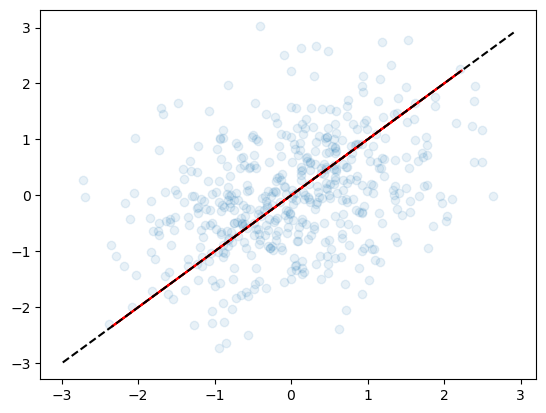

In [252]:
# Visualize projection onto longest semi-axis (=top eigenvector)
X_proj = T.reshape(-1,1)*ordered[0][1]
plt.plot(X_proj[:,0], X_proj[:,1], 'r') # Axes we projected onto in red
plt.scatter(X_std[:,0], X_std[:,1], alpha=0.1)
utils.add_line([0, ordered[0][1][1]/ordered[0][1][0]]) # Plot top eigenvector in black

In [255]:
# Use sklearn to do PCA
pca = PCA(n_components=1)
_ = pca.fit(X_std)

In [263]:
# You can get the scores from sklearn easily
sklearn_scores = pca.transform(X_std) # np.matmul(X_std, pca.components_.T)

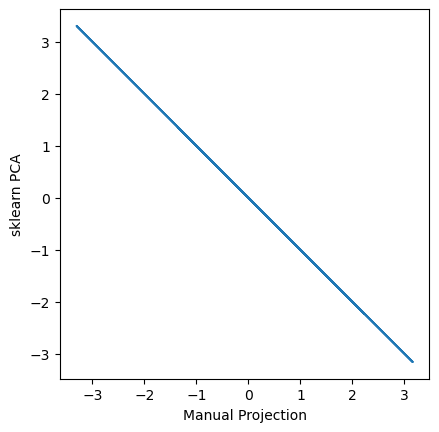

In [264]:
# Note that the sign of the eigenvectors is liable to swap randomly.  This does not affect things practically
# but it can lead to difference is the apparent projection "direction".
plt.plot(
    T, 
    sklearn_scores
)
_ = plt.gca().set(aspect='equal', xlabel='Manual Projection', ylabel='sklearn PCA')

In [258]:
# These are the "loadings"
pca.components_ 

array([[-0.70710678, -0.70710678]])

In [265]:
# You can extract the top k eigenvalues from PCA like this.
pca.explained_variance_

array([1.36461707])

If we create a model of some data like:

$X = TP^T + E$

then $T$ is the **"scores" matrix** and $P$ is the **"loading" matrix.** A helpful definition of the [loading matrices](https://stats.stackexchange.com/questions/143905/loadings-vs-eigenvectors-in-pca-when-to-use-one-or-another) can be found on stackexchange. For PCA the $P$ matrix is clearly related to the eigenvectors. Recall that an orthonormal matrix (columns and rows are orthonormal), $A$, has the property that $AA^T = I$; thus, $A^{-1}AA^T = A^{-1}I$ or $A^T = A^{-1}$.  Since the inverse is equal to its transpose, clearly the above expressions (ignoring error term) we can be rearranged to look like $XP = T$.  This reveals that P is the matrix of top eigenvectors (see above); sometimes eigenvectors are scaled to unit vectors so you will see this multiplied by the square root of the eigenvalues (recall these are found from covariance of e.g., $A^TA$, so we need to "remove the square") to restore their "size" (as in the link above). This is a nice [graphical explanation](https://stats.stackexchange.com/questions/119746/what-is-the-proper-association-measure-of-a-variable-with-a-pca-component-on-a/119758#119758).  **Because of data scaling, it seems like this gets lost or overlooked, but works out because of the unit scale.**

<h3>Relationship to SVD</h3>

<h3>About That Normalization Factor...</h3>

Principal Components Regression (PCR)
---